In [2]:
import os
import numpy as np 
import nibabel as nb
import pandas as pd
import nilearn
import matplotlib.pyplot as plt
import nilearn.plotting
from nilearn.image import resample_img
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# sorting & plotting

In [3]:
def sort_zaverages(zmaps, zaverages):

    # zmaps: list of topic strings
    # zaverages: numpy array
    ylabels = [os.path.split(fname)[-1] 
               for fname in zmaps]

    tmp_zaverages = zaverages
    index_sort    = np.argsort(np.argmax(tmp_zaverages, axis=1))
    tmp_sorted    = tmp_zaverages[index_sort, :]

    ylabels_sorted = []
    for i in range(0, len(index_sort)):
        ylabels_sorted.append(ylabels[index_sort[i]])

    df_zscore     = pd.DataFrame(index = ylabels_sorted,
                                 data = tmp_sorted)
    return df_zscore

In [4]:
def plot_sorted_df(df_zscore, thr, vmax, figsize=None):

    df = []
    df = df_zscore.copy()
    df[df<thr] = 0 

    sns.set(context="paper", 
            font="sans-serif", 
            font_scale=3.8)
    
    if figsize == None:
        f, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(15, 10), sharey=True)
    else: 
        f, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=figsize, sharey=True)
        
    plotData = df
    cax = sns.heatmap(plotData, 
                      linewidths=1, 
                      square=True, 
                      cmap='Greys', 
                      robust=False, 
                      ax=ax1, 
                      vmin = thr, 
                      vmax = vmax, 
                      mask=plotData == 0,
                      )

    percentiles = range(20)
    cax.set_xticks(np.arange(0.5, len(percentiles), 1))
    cax.set_xticklabels(['0-5', '5-10', '10-15', '15-20', '20-25',
                         '25-30', '30-35', '35-40', '40-45', '45-50',
                         '50-55', '55-60', '60-65', '65-70', '70-75',
                         '75-80', '80-85', '85-90', '90-95', '95-100'], 
                          rotation=90)
    cbar = cax.collections[0].colorbar
    cbar.set_label('z-stat', labelpad=-30, rotation=270)
    cbar.set_ticks(ticks=[thr,vmax])
    cbar.set_ticklabels(ticklabels=[('%1.1f' % thr), ('%1.1f' % vmax)])
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(0.5)

    plt.draw()
    f.tight_layout()
    return f

# binning and resampling gradients

## # resampling gradient to neurosynth space

In [5]:
template_file = '/data/pt_mar006/neurosynth/grad_daniel_volume_95_100.nii.gz'
template      = nb.load(template_file)

myfile    = '/data/pt_mar006/subjects_group/mni3_component_3_reverse.nii.gz'
mymap     = nb.load(myfile)
mysampled = resample_img(mymap,
                         target_affine = template.affine,
                         target_shape  = template.shape)

mysampled.to_filename('/data/pt_mar006/neurosynth/grad_3_resampled.nii.gz')

## # resampling and binarizing GM mask file to neurosynth space

In [6]:
gmfile    = '/data/pt_mar006/subjects_group/mni3_rest_gm_mask.nii.gz'
gmmap     = nb.load(gmfile)
gmsampled = resample_img(gmmap,
                         target_affine = template.affine,
                         target_shape  = template.shape)

gmsampled.to_filename('/data/pt_mar006/neurosynth/GM_resampled.nii.gz')

from nipype.interfaces.fsl.maths import MathsCommand

binarize = MathsCommand()
binarize.inputs.args     = '-thr  0.30 -bin'
binarize.inputs.in_file  = '/data/pt_mar006/neurosynth/GM_resampled.nii.gz'
binarize.inputs.out_file = '/data/pt_mar006/neurosynth/GM_resampled_mask.nii.gz'
binarize.run()


## #get binary gradient masks given bin numbers

In [7]:
def gradient_bins(grad_file,  
                  gm_file,
                  temp_file,
                  out_dir,
                  bins):

    data = nb.load(grad_file).get_data()
    
    mask_array = nb.load(gm_file).get_data()
    voxel_x    = np.where(mask_array==1)[0]
    voxel_y    = np.where(mask_array==1)[1]
    voxel_z    = np.where(mask_array==1)[2]
    
    a = data[voxel_x, voxel_y, voxel_z]
    
    # sort from highest to lowest value
    data_argsort = np.argsort(a)[::-1]

    steps        = int((1/float(bins))*len(a))
    boxperc      = int(100/bins)
        
    temp = nb.load(temp_file)
    
    for thisperc in range(bins):
        
        abin  = np.zeros(a.shape)
        index = data_argsort[thisperc*steps :(thisperc+1)*steps+1] 
        abin[index] = 1.0
        
        data_temp  = np.zeros(temp.get_data().shape)
        data_temp[voxel_x, voxel_y, voxel_z] = abin
        
        # dummy string definition for filename
        boxmax = 100-(thisperc*boxperc)
        boxmin = 100-((thisperc+1)*boxperc)
        mystr  = str(boxmax) + '_' + str(boxmin)
        
        print thisperc, mystr
        
        prefix    = 'binned_' + mystr + '.nii.gz'
        out_file  = os.path.join(out_dir, prefix)      
        img_temp  = nb.Nifti1Image(data_temp, temp.get_affine())
        nb.save(img_temp, out_file)
        
    return

# Gradient 3

In [8]:
grad_file = '/data/pt_mar006/neurosynth/grad_3_resampled.nii.gz'
gm_file   = '/data/pt_mar006/neurosynth/GM_resampled_mask.nii.gz'
temp_file = '/data/pt_mar006/neurosynth/grad_daniel_volume_95_100.nii.gz'
out_dir   = '/data/pt_mar006/neurosynth/bins_grad_3/'
bins      = 20

gradient_bins(grad_file,
              gm_file,
              temp_file,
              out_dir,
              bins)


0 100_95
1 95_90
2 90_85
3 85_80
4 80_75
5 75_70
6 70_65
7 65_60
8 60_55
9 55_50
10 50_45
11 45_40
12 40_35
13 35_30
14 30_25
15 25_20
16 20_15
17 15_10
18 10_5
19 5_0


In [9]:
tot = 5
gradmaps = [str('/data/pt_mar006/neurosynth/bins_grad_3/binned_%d_%d.nii.gz' 
                % (i * tot + tot, i * tot)) 
            for i in np.arange(20) ]
gradmaps

['/data/pt_mar006/neurosynth/bins_grad_3/binned_5_0.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_10_5.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_15_10.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_20_15.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_25_20.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_30_25.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_35_30.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_40_35.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_45_40.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_50_45.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_55_50.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_60_55.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_65_60.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_70_65.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_75_70.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_3/binned_80_75.nii.

# here we go...

In [10]:
from neurosynth import Dataset
from neurosynth import meta, decode, network
# Create a new Dataset instance
# database.txt and features.txt extracted from current_data.tar.gz
# the current data downloaded from:
# https://github.com/neurosynth/neurosynth-data
# dataset = Dataset('/data/pt_mar006/data/database.txt')
# dataset.add_features('/data/pt_mar006/data/features.txt')
# dataset.save('/data/pt_mar006/data/dataset.pkl')
# features = pd.read_csv('/data/pt_mar006/tmp/analyses/v4-topics-50.txt', 
#                       sep='\t', index_col=0)
# features.columns gives the column names from topic list

In [11]:
dataset = pd.read_pickle('/data/pt_mar006/neurosynth/data/dataset.pkl')

In [12]:
features       = pd.read_csv('/data/pt_mar006/neurosynth/analyses/v4-topics-50.txt', 
                             sep='\t', index_col=0)
labels         = features.columns

topics_to_keep = [ 0,  1,  2,  3,  5,  8,  11, 12, 15, 
                   17,  19, 20, 22, 23, 29, 32,
                    37, 40, 41, 42,  44, 47, 48, 49]

nice_labels_dic = {}

nice_labels_dic["0_action_actions_motor"] = 'action'
nice_labels_dic["1_object_objects_category"] = 'object recognition'
nice_labels_dic["2_task_performance_cognitive"] = 'executive function'
nice_labels_dic["3_visual_auditory_sensory"] = 'multisensory proc.'
nice_labels_dic["5_face_faces_recognition"] = 'face recognition'
nice_labels_dic["8_inhibition_response_inhibitory"] = 'inhibition'
nice_labels_dic["11_motion_visual_perception"] = 'visual perception'
nice_labels_dic["12_memory_retrieval_encoding"] = 'declarative mem.'
nice_labels_dic["15_eye_spatial_gaze"] = 'visuospatial'
nice_labels_dic["17_social_participants_empathy"] = 'social cognition'
nice_labels_dic["19_stimulus_responses_response"] = 'operant cond.'
nice_labels_dic["20_reading_language_words"] = 'reading'
nice_labels_dic["22_memory_working_wm"] = 'working memory'
nice_labels_dic["23_emotional_faces_facial"] = 'face-affective proc.' ### slash missing
nice_labels_dic["29_reward_decision_risk"] = 'reward-based dec.'
nice_labels_dic["32_speech_auditory_sounds"] = 'auditory proc.'
nice_labels_dic["35_stimulation_somatosensory_tms"] = 'somatosensory'
nice_labels_dic["37_age_adults_aging"] = 'aging'
nice_labels_dic["40_emotional_negative_emotion"] = 'emotion'
nice_labels_dic["41_attention_attentional_visual"] = 'visual attention'
nice_labels_dic["42_number_numerical_arithmetic"] = 'numerical cog.'
nice_labels_dic["44_semantic_words_word"] = 'verbal semantics'
nice_labels_dic["47_conflict_response_trials"] = 'cognitive control'
nice_labels_dic["48_pain_painful_stimulation"] = 'pain'
nice_labels_dic["49_motor_movement_movements"] = 'motor'


features_to_keep = features.iloc[:, topics_to_keep]
labels_to_keep = []
for col in features_to_keep.columns:
    # use nicer label names if we have some defined yet
    if col in nice_labels_dic:
        col = nice_labels_dic[col]
    labels_to_keep.append(col)

features = features.iloc[:, topics_to_keep]
features.columns = labels_to_keep


24


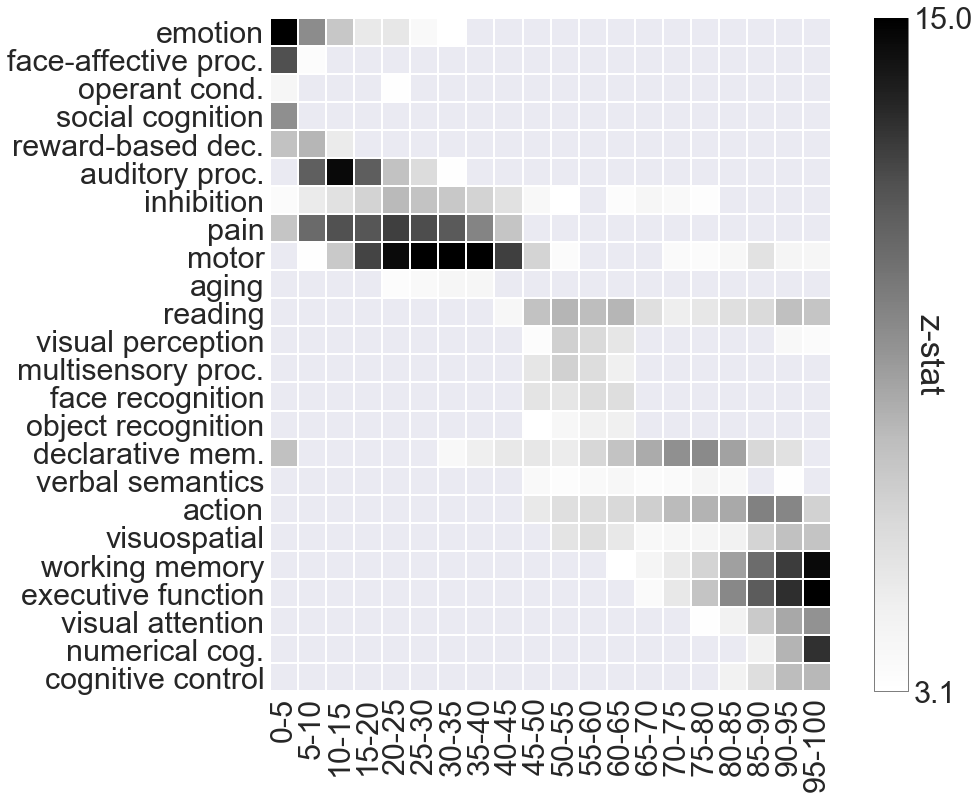

In [13]:
dataset.add_features(features, append=False)
decoder = decode.Decoder(dataset, method='roi')
data = decoder.decode(gradmaps,
                      save='/data/pt_mar006/neurosynth/decoder_results_grad_3.txt')
print len(data)
df = data.copy()
df_sorted = sort_zaverages(labels_to_keep, np.array(df))
f = plot_sorted_df(df_sorted, thr=3.1, vmax=15, figsize=(15,12))

# Gradient 1

## resample

In [14]:
template_file = '/data/pt_mar006/neurosynth/grad_daniel_volume_95_100.nii.gz'
template      = nb.load(template_file)

myfile    = '/data/pt_mar006/subjects_group/mni3_component_1.nii.gz'
mymap     = nb.load(myfile)
mysampled = resample_img(mymap,
                         target_affine = template.affine,
                         target_shape  = template.shape)

mysampled.to_filename('/data/pt_mar006/neurosynth/grad_1_resampled.nii.gz')

## get binned masks

In [15]:
grad_file = '/data/pt_mar006/neurosynth/grad_1_resampled.nii.gz'
gm_file   = '/data/pt_mar006/neurosynth/GM_resampled_mask.nii.gz'
temp_file = '/data/pt_mar006/neurosynth/grad_daniel_volume_95_100.nii.gz'
out_dir   = '/data/pt_mar006/neurosynth/bins_grad_1/'
bins      = 20

gradient_bins(grad_file,
              gm_file,
              temp_file,
              out_dir,
              bins)

0 100_95
1 95_90
2 90_85
3 85_80
4 80_75
5 75_70
6 70_65
7 65_60
8 60_55
9 55_50
10 50_45
11 45_40
12 40_35
13 35_30
14 30_25
15 25_20
16 20_15
17 15_10
18 10_5
19 5_0


In [16]:
tot = 5
gradmaps = [str('/data/pt_mar006/neurosynth/bins_grad_1/binned_%d_%d.nii.gz' 
                % (i * tot + tot, i * tot)) 
            for i in np.arange(20) ]
gradmaps

['/data/pt_mar006/neurosynth/bins_grad_1/binned_5_0.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_10_5.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_15_10.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_20_15.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_25_20.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_30_25.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_35_30.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_40_35.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_45_40.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_50_45.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_55_50.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_60_55.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_65_60.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_70_65.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_75_70.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_1/binned_80_75.nii.

In [17]:
features       = pd.read_csv('/data/pt_mar006/neurosynth/analyses/v4-topics-50.txt', 
                             sep='\t', index_col=0)
labels         = features.columns

topics_to_keep = [ 0,  1,  2,  3,  5,  8,  11, 12, 15, 
                   17, 19, 20,  22, 29, 32, 
                   36, 40, 41, 44, 48, 49, 35]

nice_labels_dic = {}
nice_labels_dic["0_action_actions_motor"] = 'action'
nice_labels_dic["1_object_objects_category"] = 'object recognition'
nice_labels_dic["2_task_performance_cognitive"] = 'executive function'
nice_labels_dic["3_visual_auditory_sensory"] = 'multisensory proc.'
nice_labels_dic["5_face_faces_recognition"] = 'face recognition'
nice_labels_dic["8_inhibition_response_inhibitory"] = 'inhibition'
nice_labels_dic["11_motion_visual_perception"] = 'visual perception'
nice_labels_dic["12_memory_retrieval_encoding"] = 'declarative mem.'
nice_labels_dic["15_eye_spatial_gaze"] = 'visuospatial'
nice_labels_dic["17_social_participants_empathy"] = 'social cognition'
nice_labels_dic["19_stimulus_responses_response"] = 'operant cond.'
nice_labels_dic["20_reading_language_words"] = 'reading'
nice_labels_dic["22_memory_working_wm"] = 'working memory'
nice_labels_dic["29_reward_decision_risk"] = 'reward-based dec.'
nice_labels_dic["32_speech_auditory_sounds"] = 'auditory proc.'
nice_labels_dic["35_stimulation_somatosensory_tms"] = 'somatosensory'
nice_labels_dic["36_sentences_comprehension_language"] = 'language'
nice_labels_dic["40_emotional_negative_emotion"] = 'emotion'
nice_labels_dic["41_attention_attentional_visual"] = 'visual attention'
nice_labels_dic["44_semantic_words_word"] = 'verbal semantics'
nice_labels_dic["48_pain_painful_stimulation"] = 'pain'
nice_labels_dic["49_motor_movement_movements"] = 'motor'


features_to_keep = features.iloc[:, topics_to_keep]
labels_to_keep = []
for col in features_to_keep.columns:
    # use nicer label names if we have some defined yet
    if col in nice_labels_dic:
        col = nice_labels_dic[col]
    labels_to_keep.append(col)



22


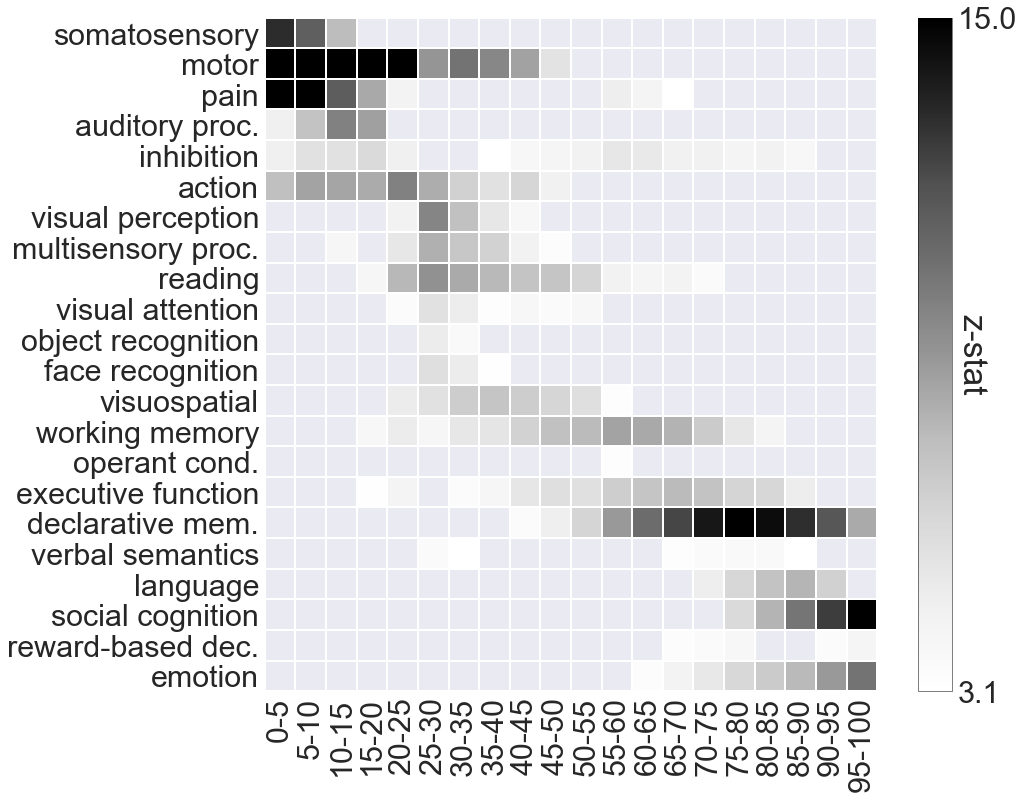

In [18]:
dataset.add_features(features_to_keep, append=False)
decoder = decode.Decoder(dataset, method='roi')#
data = decoder.decode(gradmaps,
                      save='/data/pt_mar006/neurosynth/decoder_results_grad_1.txt')
print len(data)
df = data.copy()

df_sorted = sort_zaverages(labels_to_keep, np.array(df))
f = plot_sorted_df(df_sorted, thr=3.1, vmax=15, figsize=(15,12))


# Gradient 2

In [19]:
template_file = '/data/pt_mar006/neurosynth/grad_daniel_volume_95_100.nii.gz'
template      = nb.load(template_file)

myfile    = '/data/pt_mar006/subjects_group/mni3_component_2_reverse.nii.gz'
mymap     = nb.load(myfile)
mysampled = resample_img(mymap,
                         target_affine = template.affine,
                         target_shape  = template.shape)

mysampled.to_filename('/data/pt_mar006/neurosynth/grad_2_resampled.nii.gz')

In [20]:
grad_file = '/data/pt_mar006/neurosynth/grad_2_resampled.nii.gz'
gm_file   = '/data/pt_mar006/neurosynth/GM_resampled_mask.nii.gz'
temp_file = '/data/pt_mar006/neurosynth/grad_daniel_volume_95_100.nii.gz'
out_dir   = '/data/pt_mar006/neurosynth/bins_grad_2/'
bins      = 20

gradient_bins(grad_file,
              gm_file,
              temp_file,
              out_dir,
              bins)

0 100_95
1 95_90
2 90_85
3 85_80
4 80_75
5 75_70
6 70_65
7 65_60
8 60_55
9 55_50
10 50_45
11 45_40
12 40_35
13 35_30
14 30_25
15 25_20
16 20_15
17 15_10
18 10_5
19 5_0


In [21]:
tot = 5
gradmaps = [str('/data/pt_mar006/neurosynth/bins_grad_2/binned_%d_%d.nii.gz' 
                % (i * tot + tot, i * tot)) 
            for i in np.arange(20) ]
gradmaps

['/data/pt_mar006/neurosynth/bins_grad_2/binned_5_0.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_10_5.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_15_10.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_20_15.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_25_20.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_30_25.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_35_30.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_40_35.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_45_40.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_50_45.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_55_50.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_60_55.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_65_60.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_70_65.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_75_70.nii.gz',
 '/data/pt_mar006/neurosynth/bins_grad_2/binned_80_75.nii.

In [22]:
features       = pd.read_csv('/data/pt_mar006/neurosynth/analyses/v4-topics-50.txt', 
                             sep='\t', index_col=0)
labels         = features.columns

topics_to_keep = [ 0,  1,  2,  3,  5,  8, 11, 12, 15, 
                   17, 19, 20, 22, 23,  25, 29, 32, 
                   35, 36, 37, 40, 41, 44, 47, 48, 49]
 
nice_labels_dic["0_action_actions_motor"] = 'action'
nice_labels_dic["1_object_objects_category"] = 'object recognition'
nice_labels_dic["2_task_performance_cognitive"] = 'executive function'
nice_labels_dic["3_visual_auditory_sensory"] = 'multisensory proc.'
nice_labels_dic["5_face_faces_recognition"] = 'face recognition'
nice_labels_dic["8_inhibition_response_inhibitory"] = 'inhibition'
nice_labels_dic["11_motion_visual_perception"] = 'visual perception'
nice_labels_dic["12_memory_retrieval_encoding"] = 'declarative mem.'
nice_labels_dic["15_eye_spatial_gaze"] = 'visuospatial'
nice_labels_dic["17_social_participants_empathy"] = 'social cognition'
nice_labels_dic["19_stimulus_responses_response"] = 'operant cond.'
nice_labels_dic["20_reading_language_words"] = 'reading'
nice_labels_dic["22_memory_working_wm"] = 'working memory'
nice_labels_dic["23_emotional_faces_facial"] = 'face-affective proc.' ### slash missing
nice_labels_dic["25_learning_feedback_error"] = 'reinforcement lear.'
nice_labels_dic["29_reward_decision_risk"] = 'reward-based dec.'
nice_labels_dic["32_speech_auditory_sounds"] = 'auditory proc.'
nice_labels_dic["35_stimulation_somatosensory_tms"] = 'somatosensory'
nice_labels_dic["36_sentences_comprehension_language"] = 'language'
nice_labels_dic["40_emotional_negative_emotion"] = 'emotion'
nice_labels_dic["41_attention_attentional_visual"] = 'visual attention'
nice_labels_dic["44_semantic_words_word"] = 'verbal semantics'
nice_labels_dic["47_conflict_response_trials"] = 'cognitive control'
nice_labels_dic["48_pain_painful_stimulation"] = 'pain'
nice_labels_dic["49_motor_movement_movements"] = 'motor'


features_to_keep = features.iloc[:, topics_to_keep]
labels_to_keep = []
for col in features_to_keep.columns:
    # use nicer label names if we have some defined yet
    if col in nice_labels_dic:
        col = nice_labels_dic[col]
    labels_to_keep.append(col)



26


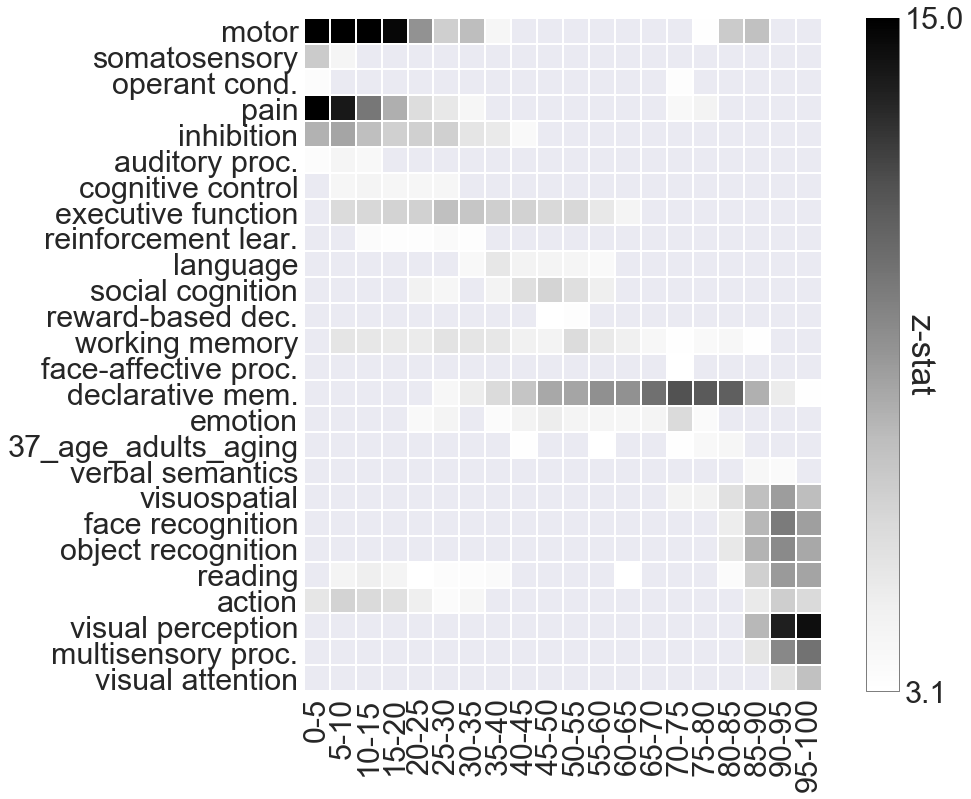

In [23]:
dataset.add_features(features_to_keep, append=False)
decoder = decode.Decoder(dataset, method='roi')#
data = decoder.decode(gradmaps,
                      save='/data/pt_mar006/neurosynth/decoder_results_grad_2.txt')
print len(data)
df = data.copy()

df_sorted = sort_zaverages(labels_to_keep, np.array(df))
f = plot_sorted_df(df_sorted, thr=3.1, vmax=15, figsize=(15,12))